In [209]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [211]:
# Experiment configuration
experiment_name = "dpf_feb18_biggermodel_biggerdataset"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [212]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel()
measurement_model = panda_models.PandaSimpleMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"]
)

[buddy-dpf_feb18_biggermodel_biggerdataset] Using device: cuda
[buddy-dpf_feb18_biggermodel_biggerdataset] No checkpoint found


# Dynamics Model Pre-Training

In [213]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_1000.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=32,
    **dataset_args
)

Parsed data: 176075 active, 62925 inactive
Keeping: 62925


In [215]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1)
    print()


Training epoch 0



Epoch loss: 0.0024421772

Training epoch 1


[buddy-dpf_feb18_biggermodel_biggerdataset] Saved checkpoint to path: checkpoints/dpf_feb18_biggermodel_biggerdataset-0000000000010000.ckpt

Epoch loss: 0.0021916446

Training epoch 2


[buddy-dpf_feb18_biggermodel_biggerdataset] Saved checkpoint to path: checkpoints/dpf_feb18_biggermodel_biggerdataset-0000000000020000.ckpt

Epoch loss: 0.0019349832

Training epoch 3



Epoch loss: 0.0018125732

Training epoch 4


[buddy-dpf_feb18_biggermodel_biggerdataset] Saved checkpoint to path: checkpoints/dpf_feb18_biggermodel_biggerdataset-0000000000030000.ckpt

Epoch loss: 0.0017518617



In [217]:
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2')
    print()


Training epoch 0



Epoch loss: 0.0067711486

Training epoch 1


KeyboardInterrupt: 

# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_100.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [ ]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=64,
    shuffle=True,
    num_workers=16)

for i in range(15):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



In [ ]:
buddy.save_checkpoint(label="before_e2e_training")

# End-to-end Training

In [ ]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_100.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

In [ ]:
print(len(e2e_trainset.subsequences))

In [ ]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.05, 0.05)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(20):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

In [ ]:
buddy.save_checkpoint()

# Model eval

In [186]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

### Final Model

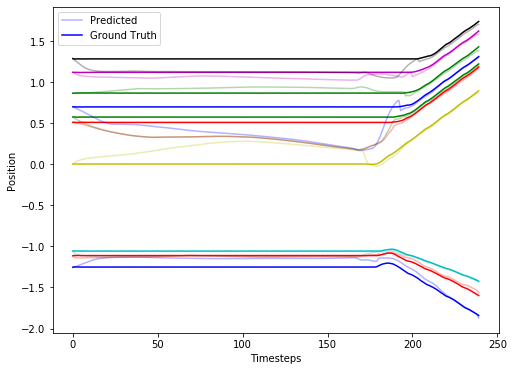

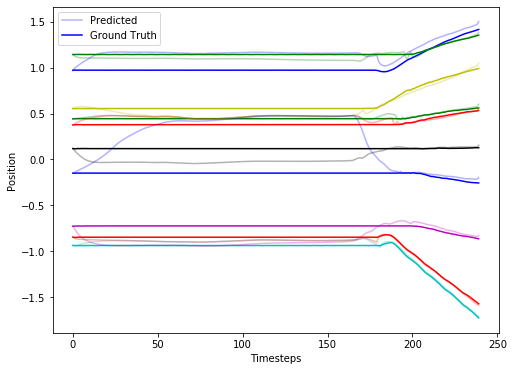

X RMSE:  0.15730508568906307
Y RMSE:  0.17044337895142314
(0.0, 0.0)


In [216]:
pf_model.dynamics_model.state_noise_stddev = (0., 0.)
# pf_model.dynamics_model.state_noise_stddev = (1., 1.)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

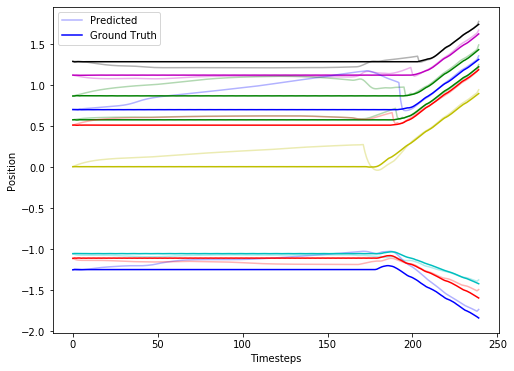

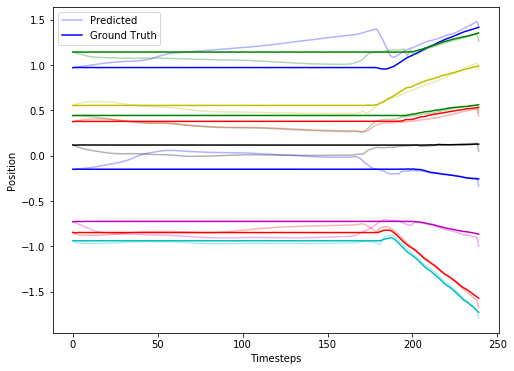

X RMSE:  0.12261221656206368
Y RMSE:  0.10703645362977164
(0.0, 0.0)


In [218]:
pf_model.dynamics_model.state_noise_stddev = (0., 0.)
# pf_model.dynamics_model.state_noise_stddev = (1., 1.)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
pf_model.dynamics_model.state_noise = (0.005, 0.005)


# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)

# Restore model
buddy.load_checkpoint()